In [1]:
import scipy as sp
from src.utils import load_sparse_adj_mat, load_design_matrix
import numpy as np

# Settings
train_data_name = 'swissprot'
embed_type = 'esm'
inner_kfold = 5
outer_kfold = 5
hpo_metric = 'f1_weighted'
do_save = True

# Load dataset
y, idx_sample, idx_feature = load_sparse_adj_mat(train_data_name)
sample_idx = {v:k for k,v in idx_sample.items()}

Constructing swissprot sparse adjacency matrix


In [5]:
# Count low sample number classes
sample_cts = np.array(y.sum(axis=0))
for i in range(1,9):
    print(i, len(sample_cts[sample_cts == i]))

print(min(sample_cts))
print(len(sample_cts[sample_cts < 9]))

1 1360
2 636
3 419
4 291
5 228
6 169
7 120
8 113
1
3336


In [5]:
class_cts = np.array(y.sum(axis=0)).reshape(-1,)
srt_zip = list(sorted(zip(class_cts, np.arange(y.shape[1])), reverse=True))
n = 1000
top_n_class_idxs = np.array([elt[1] for elt in srt_zip[:n]])

# Save y (sparse)
yn = y[:, top_n_class_idxs]
nz_rows = np.array(yn.sum(axis=1)).reshape(-1,) != 0
yn = yn[nz_rows, :]
sp.sparse.save_npz(f"/scratch/spn1560/swissprot_esm_y_top_{n}_classes.npz", yn)

# Load X
X = np.load("/scratch/spn1560/swissprot_esm_X.npy")

# Index
Xn = X[nz_rows, :]

# Save X (dense)
np.save(f"/scratch/spn1560/swissprot_esm_X_top_{n}_classes.npy", Xn)

print(Xn.shape, yn.shape)

(207892, 1280) (207892, 1000)


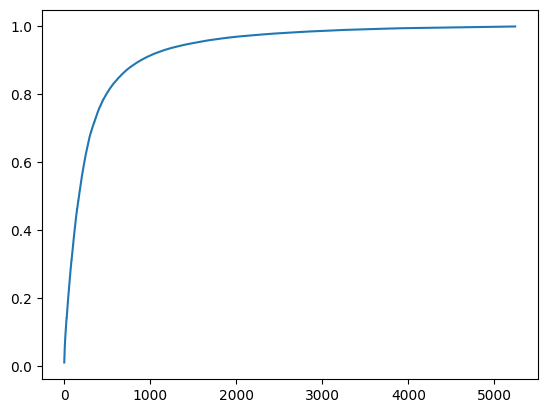

In [42]:
import matplotlib.pyplot as plt

n_classes = np.arange(1, y.shape[1] + 1)
n_samples = []
for n in n_classes:
    class_cts = np.array(y.sum(axis=0)).reshape(-1,)
    srt_zip = list(sorted(zip(class_cts, np.arange(y.shape[1])), reverse=True))
    top_n_class_idxs = np.array([elt[1] for elt in srt_zip[:n]])

    # Save y (sparse)
    yn = y[:, top_n_class_idxs]
    nz_rows = np.array(yn.sum(axis=1)).reshape(-1,) != 0
    yn = yn[nz_rows, :]

    n_samples.append(yn.shape[0])

frac_samples = np.array(n_samples) / y.shape[0]

plt.plot(n_classes, frac_samples)
plt.show()

In [49]:
np.argwhere(frac_samples > 0.80)[0]

array([488])

In [48]:
frac_samples[150]

0.4624563471468407

In [1]:
import pickle
import sklearn

with open(f"../artifacts/trained_models/240412_18_20_17_random_forest_train_data_swissprot_esm_embeddings_model_no_2_exploratory.pkl", 'rb') as f:
    clf = pickle.load(f)

: 

: 

: 

In [4]:
clf.n_estimators

1